# Mini-batch FashionMNIST

We shall train a tiny (under 10k params) FashionMNIST convolutional neural network using mini-batch training.

**See also**: The full-batch FashionMNIST notebook uses the same model and dataset, but with full-batch training.

### 1. Introduction

For mini-batch training my brief recommendation is to start with SOAP unless it is too slow to compute, then try AdamW and SGD. If batch size is large, Muon can be a good alternative to SOAP with less memory usage. A particular SOAP variant that works really well is this:

```py
[
    tz.m.SOAP(),
    tz.m.NormalizeByEMA(max_ema_growth=1.2),
    tz.m.WeightDecay(1e-2),
    tz.m.LR(lr)
]
```

Other than that there are way too many stochastic optimizers, each potentially excelling in some specific scenarios.

### 2. Imports

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torchzero as tz
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
import tqdm
import numpy as np
import random
from torchvision.datasets import FashionMNIST
from light_dataloader import TensorDataLoader

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

### 3. Load the dataset

FashionMNIST is like MNIST but a bit harder. Each sample is a single channel 28x28 image and an integer label from 0 to 9.

I stacked the entire dataset into a tensor and moved to GPU for efficiency.

In [2]:
def to_tensors(ds):
    inputs = []
    targets = []
    for input, target in ds:
        inputs.append(torch.tensor(np.array(input), dtype=torch.float32))
        targets.append(torch.tensor(np.array(target), dtype=torch.long))

    # znormalize
    inputs = torch.stack(inputs)
    inputs = (inputs - inputs.mean() / inputs.std())

    return inputs.cuda(), torch.stack(targets).cuda()

fm_train = FashionMNIST("/var/mnt/wwn-0x5000039a52582e84-part1/datasets/FashionMNIST", train=True, download=True)
fm_test = FashionMNIST("/var/mnt/wwn-0x5000039a52582e84-part1/datasets/FashionMNIST", train=False, download=True)

train_X, train_y = to_tensors(fm_train)
test_X, test_y = to_tensors(fm_test)

train_X.unsqueeze_(1)
test_X.unsqueeze_(1)

dl_train = TensorDataLoader((train_X, train_y), batch_size=32, shuffle=True, memory_efficient=True, seed=0)
dl_test = TensorDataLoader((test_X, test_y), batch_size=1024, shuffle=False, memory_efficient=True, seed=0)

train_X.shape, train_y.shape, test_X.shape, test_y.shape

(torch.Size([60000, 1, 28, 28]),
 torch.Size([60000]),
 torch.Size([10000, 1, 28, 28]),
 torch.Size([10000]))

### 4. Define the model

We use a 4-layer convolutional net with 9.6k parameters. The same model was used for full-batched training in another notebook and achieved 90% test accuracy.

In [3]:
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

class TinyConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.c1 = nn.Conv2d(1, 16, 3, 2)
        self.c2 = nn.Conv2d(16, 24, 3, 2)
        self.c3 = nn.Conv2d(24, 32, 2, 2)
        self.head = nn.Sequential(nn.Flatten(), nn.Linear(32*9, 10))

    def forward(self, x):
        x = F.elu(self.c1(x), inplace=True)
        x = F.elu(self.c2(x), inplace=True)
        x = F.elu(self.c3(x), inplace=True)
        return self.head(x)

print(TinyConvNet()(torch.randn(1,1,28,28)).shape)
count_params(TinyConvNet())

torch.Size([1, 10])


9634

### 5. Define the training function

This works with any pytorch optimizer, not just torchzero. Here closure isn't necessary and can be omitted, but I tend to include it just in case. For example, if you choose to add sharpness-aware minimization, or use the AdaHessian optimizer, they require a closure, so it's good to have one already in place.

In [4]:
def train_epoch(dl_train, model, opt, scheduler, criterion):
    losses = []
    accs = []

    for x, y in tqdm.tqdm(dl_train, leave=False, desc='train'):

        accuracy = None

        def closure(backward=True):
            y_hat = model(x)
            loss = criterion(y_hat, y)
            if backward:
                opt.zero_grad()
                loss.backward()

            with torch.no_grad():
                nonlocal accuracy
                accuracy = (y_hat.argmax(-1) == y).float().mean()

            return loss

        loss = opt.step(closure)
        if scheduler is not None: scheduler.step()
        losses.append(loss.detach().cpu())
        accs.append(accuracy.detach().cpu()) # type:ignore

    return losses, accs

@torch.no_grad
def test_epoch(dl_test, model, criterion):
    losses = []
    accs = []

    for x, y in tqdm.tqdm(dl_test, leave=False, desc='test'):
        y_hat = model(x)
        loss = criterion(y_hat, y)
        accuracy = (y_hat.argmax(-1) == y).float().mean()
        losses.append(loss.detach().cpu())
        accs.append(accuracy.detach().cpu())

    return losses, accs

def run(opt_fn, epochs: int, scheduler_fn=None):
    dl_train.reset_rng()
    model = TinyConvNet().cuda()
    opt = opt_fn(model.parameters())
    scheduler = None if scheduler_fn is None else scheduler_fn(opt)
    criterion = F.cross_entropy

    train_losses = []
    train_acc = []
    test_losses = {}
    test_acc = {}

    losses, accs = test_epoch(dl_train, model, criterion)
    test_losses[len(train_losses)] = np.mean(losses)
    test_acc[len(train_losses)] = np.mean(accs)

    for epoch in tqdm.trange(epochs):
        losses, accs = train_epoch(dl_train, model, opt, scheduler, criterion)
        train_losses.extend(losses)
        train_acc.extend(accs)

        losses, accs = test_epoch(dl_train, model, criterion)
        test_losses[len(train_losses)] = np.mean(losses)
        test_acc[len(train_losses)] = np.mean(accs)

    print(f"{max(test_acc.values()) = }")
    print(f'{min(test_losses.values()) = }')

    plt.plot(train_acc, label='train')
    plt.plot(gaussian_filter1d(train_acc, 10, mode='nearest'), label='train (smoothed)')
    plt.plot(*zip(*test_acc.items()), label='test')
    plt.xlabel('number of function evaluations')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()

    return model, train_losses, test_losses, train_acc, test_acc

### 6. Run

With this SOAP variant we achieve 95% accuracy, compared to 90% in full-batch notebook. Pretty good for a tiny 10k model.

100%|██████████| 30/30 [03:53<00:00,  7.79s/it]            


max(test_acc.values()) = np.float32(0.96678334)
min(test_losses.values()) = np.float32(0.10063846)


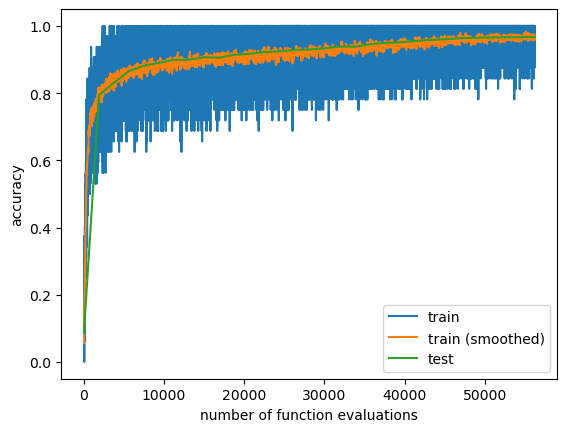

In [9]:
model, train_losses, test_losses, train_acc, test_acc = run(
    opt_fn = lambda params: tz.Modular(
        params,
        tz.m.Adam(),
        tz.m.LR(1e-3),
    ),
    epochs=30,
    scheduler_fn = lambda opt: torch.optim.lr_scheduler.OneCycleLR(opt, max_lr=1e-3, epochs=30, steps_per_epoch=len(dl_train), cycle_momentum=False)
)

test:   0%|          | 0/1875 [00:00<?, ?it/s]

100%|██████████| 30/30 [10:32<00:00, 21.08s/it]            


max(test_acc.values()) = np.float32(0.95776665)
min(test_losses.values()) = np.float32(0.11878473)


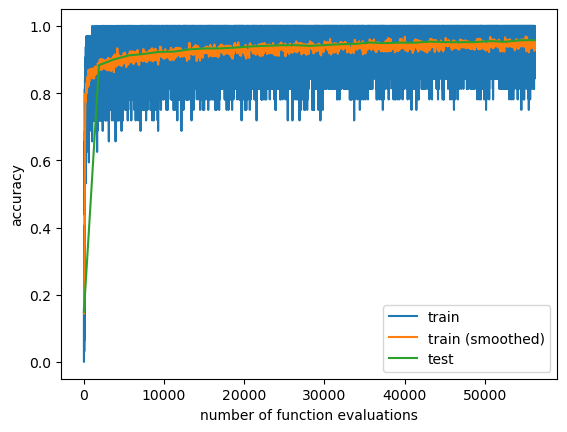

In [5]:
model, train_losses, test_losses, train_acc, test_acc = run(
    opt_fn = lambda params: tz.Modular(
        params,
        tz.m.SOAP(),
        tz.m.NormalizeByEMA(max_ema_growth=1.2),
        tz.m.LR(1e-3),
    ),
    epochs=30,
)

100%|██████████| 30/30 [13:06<00:00, 26.20s/it]            


max(test_acc.values()) = np.float32(0.9518167)
min(test_losses.values()) = np.float32(0.14202842)


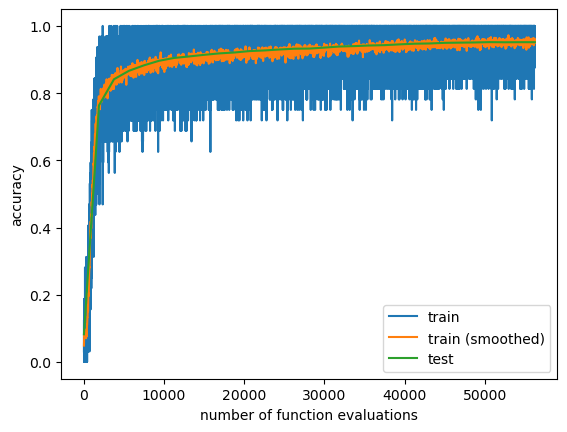

In [12]:
model, train_losses, test_losses, train_acc, test_acc = run(
    opt_fn = lambda params: tz.Modular(
        params,
        tz.m.SOAP(),
        tz.m.NormalizeByEMA(max_ema_growth=1.2),
        tz.m.LR(1e-3),
    ),
    epochs=30,
    scheduler_fn = lambda opt: torch.optim.lr_scheduler.OneCycleLR(opt, max_lr=1e-3, epochs=30, steps_per_epoch=len(dl_train), cycle_momentum=False)
)

100%|██████████| 30/30 [10:10<00:00, 20.36s/it]            


max(test_acc.values()) = np.float32(0.9487333)
min(test_losses.values()) = np.float32(0.13847502)


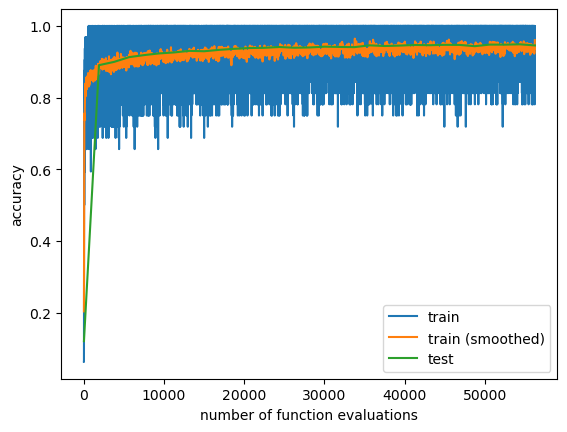

In [7]:
model, train_losses, test_losses, train_acc, test_acc = run(
    opt_fn = lambda params: tz.Modular(
        params,
        tz.m.SOAP(),
        tz.m.LR(1e-3),
    ),
    epochs=30,
)

test:   0%|          | 0/1875 [00:00<?, ?it/s]

100%|██████████| 30/30 [03:20<00:00,  6.68s/it]            


max(test_acc.values()) = np.float32(0.9446)
min(test_losses.values()) = np.float32(0.15749364)


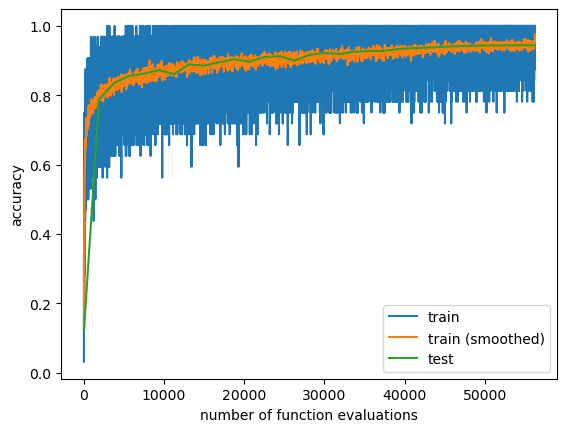

In [7]:
model, train_losses, test_losses, train_acc, test_acc = run(
    opt_fn = lambda params: tz.Modular(
        params,
        tz.m.LR(1e-2),
    ),
    epochs=30,
    scheduler_fn = lambda opt: torch.optim.lr_scheduler.OneCycleLR(opt, max_lr=1e-2, epochs=30, steps_per_epoch=len(dl_train), cycle_momentum=False)
)

100%|██████████| 30/30 [10:14<00:00, 20.49s/it]            


max(test_acc.values()) = np.float32(0.95601666)
min(test_losses.values()) = np.float32(0.12723425)


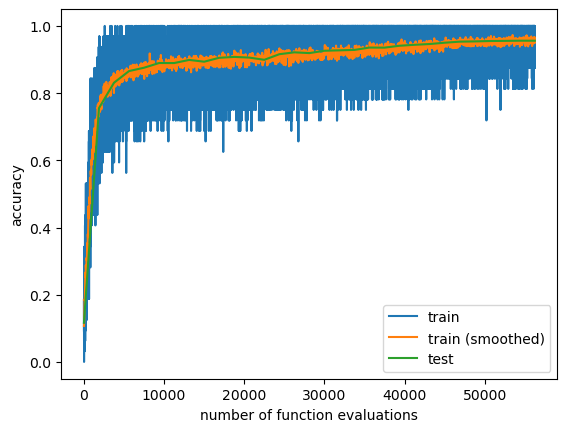

In [11]:
model, train_losses, test_losses, train_acc, test_acc = run(
    opt_fn = lambda params: tz.Modular(
        params,
        # same hyperparams as https://github.com/KellerJordan/Muon
        tz.m.NAG(0.95),
        tz.m.Split(
            lambda p: p.ndim >= 2,
            true = tz.m.Orthogonalize(),
            false = [tz.m.Adam(0.9, 0.95), tz.m.Mul(1/66)],
        ),
        tz.m.LR(1e-3),
    ),
    epochs=30,
    scheduler_fn = lambda opt: torch.optim.lr_scheduler.OneCycleLR(opt, max_lr=1e-3, epochs=30, steps_per_epoch=len(dl_train), cycle_momentum=False)
)

100%|██████████| 30/30 [04:18<00:00,  8.61s/it]            


max(test_acc.values()) = np.float32(0.9375833)
min(test_losses.values()) = np.float32(0.16599675)


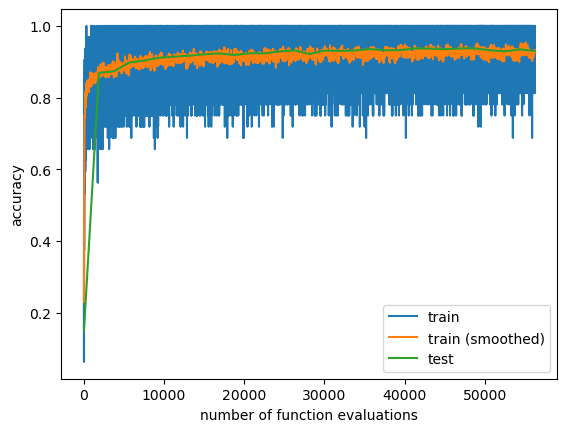

In [5]:
model, train_losses, test_losses, train_acc, test_acc = run(
    opt_fn = lambda params: tz.Modular(
        params,
        tz.m.Adam(),
        tz.m.LR(1e-3),
    ),
    epochs=30,
)

100%|██████████| 10/10 [17:55<00:00, 107.54s/it]          


max(test_acc.values()) = np.float32(0.8610167)
min(test_losses.values()) = np.float32(0.3976315)


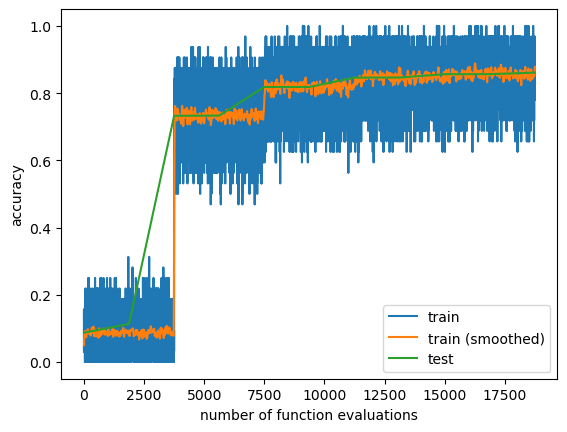

In [9]:
model, train_losses, test_losses, train_acc, test_acc = run(
    opt_fn = lambda params: tz.Modular(
        params,
        tz.m.SVRG(len(dl_train)),
        tz.m.LBFGS(100),
        tz.m.Backtracking(),
    ),
    epochs=10,
)

100%|██████████| 10/10 [07:08<00:00, 42.89s/it]           


max(test_acc.values()) = np.float32(0.85148335)
min(test_losses.values()) = np.float32(0.42413718)


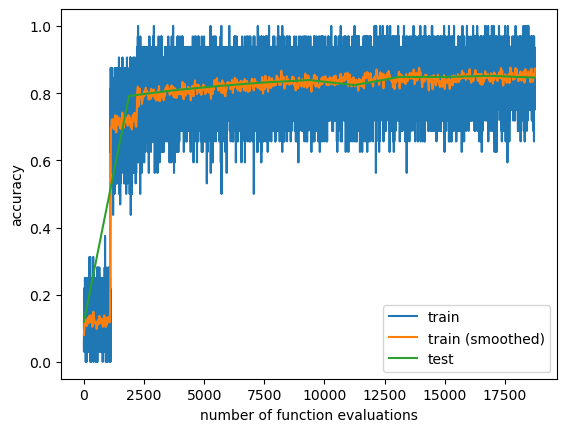

In [7]:
model, train_losses, test_losses, train_acc, test_acc = run(
    opt_fn = lambda params: tz.Modular(
        params,
        tz.m.SVRG(1000, 100),
        tz.m.LBFGS(),
        tz.m.Backtracking(),
    ),
    epochs=10,
)

100%|██████████| 10/10 [07:45<00:00, 46.60s/it]            


max(test_acc.values()) = np.float32(0.8764833)
min(test_losses.values()) = np.float32(0.34455374)


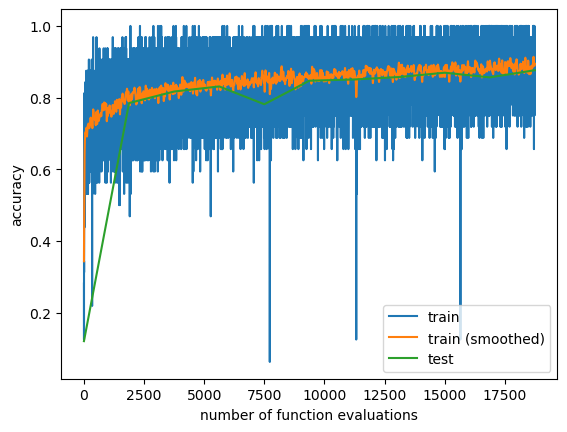

In [7]:
model, train_losses, test_losses, train_acc, test_acc = run(
    opt_fn = lambda params: tz.Modular(
        params,
        tz.m.LBFGS(),
        tz.m.Backtracking(),
    ),
    epochs=10,
)

test:   0%|          | 0/1875 [00:00<?, ?it/s]

100%|██████████| 10/10 [16:07<00:00, 96.75s/it]            


max(test_acc.values()) = np.float32(0.81453335)
min(test_losses.values()) = np.float32(0.53899175)


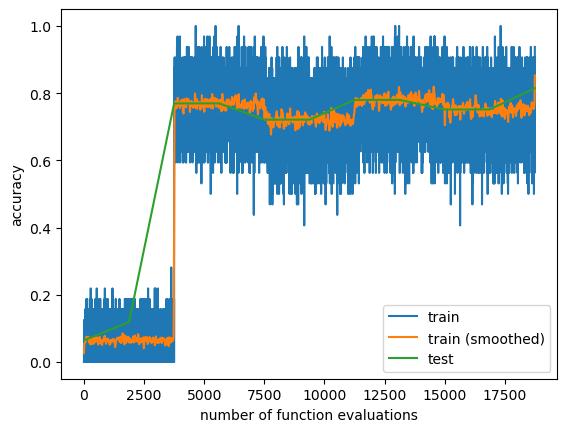

In [6]:
model, train_losses, test_losses, train_acc, test_acc = run(
    opt_fn = lambda params: tz.Modular(
        params,
        tz.m.SVRG(len(dl_train)),
        tz.m.NewtonCGSteihaug(hvp_method='forward')
    ),
    epochs=10,
)